# Earthquake Detection

In [73]:
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np

- Download waveform using Obpsy

Find earthquake information from [USGS](https://earthquake.usgs.gov/earthquakes/map/?currentFeatureId=nc73753046&extent=36.63316,-128.27637&extent=42.74701,-118.69629&range=month&settings=true)

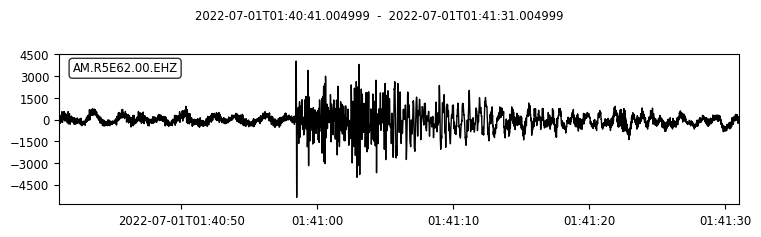

In [74]:
client = Client("RASPISHAKE")

# starttime = "2022-06-18 11:43:09"
starttime = "2022-07-01 01:40:51"
# starttime = "2022-07-05 07:21:12"
starttime = UTCDateTime(starttime) - 10
window_length = 50
waveforms = client.get_waveforms(network="AM",
                                 station="R5E62",
                                 location="*",
                                 channel="*", 
                                 # starttime=UTCDateTime("2022-06-29T14:08:04"), 
                                 # endtime=UTCDateTime("2022-06-29T14:08:04")+120)  
                                 starttime=starttime, 
                                 endtime=starttime+window_length)  
waveforms = waveforms.detrend()
waveforms[0].plot();

## Detect earthquakes using STA/LTA

In [75]:
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import plot_trigger, trigger_onset

In [86]:
tr = waveforms[0]
cft = classic_sta_lta(tr.data, int(5 * tr.stats.sampling_rate), int(10 * tr.stats.sampling_rate))
on_of = trigger_onset(cft, 1.5, 0.5)

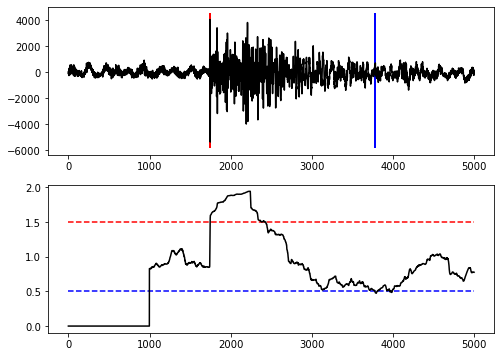

In [87]:
fig, axes = plt.subplots(2,1, figsize=(8,6))
axes[0].plot(tr.data, "k")
ymin, ymax = axes[0].get_ylim()
if len(on_of) > 0:
    axes[0].vlines(on_of[:, 0], ymin, ymax, color='r', linewidth=2)
    axes[0].vlines(on_of[:, 1], ymin, ymax, color='b', linewidth=2)
axes[1].plot(cft, 'k')
axes[1].hlines([1.5, 0.5], 0, len(cft), color=['r', 'b'], linestyle='--')
plt.show()

## Detect earthquakes using PhaseNet (Deep Learning)

In [6]:
import requests
PHASENET_API_URL = "http://phasenet.quakeflow.com"

In [7]:
waveforms

4 Trace(s) in Stream:
AM.R5E62.00.EHZ | 2022-07-01T01:40:41.004999Z - 2022-07-01T01:41:31.004999Z | 100.0 Hz, 5001 samples
AM.R5E62.00.ENE | 2022-07-01T01:40:41.004999Z - 2022-07-01T01:41:31.004999Z | 100.0 Hz, 5001 samples
AM.R5E62.00.ENN | 2022-07-01T01:40:41.004999Z - 2022-07-01T01:41:31.004999Z | 100.0 Hz, 5001 samples
AM.R5E62.00.ENZ | 2022-07-01T01:40:41.004999Z - 2022-07-01T01:41:31.004999Z | 100.0 Hz, 5001 samples

In [8]:
data = []
data.append(np.zeros_like(waveforms[0].data))
data.append(np.zeros_like(waveforms[1].data))
for trace in waveforms[0:1]:
    data.append(trace.data)
data = np.array(data).T
print(data.shape)

data_id = waveforms[0].get_id()[:-1]
timestamp = waveforms[0].stats.starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]

req = {"id": [data_id],
       "timestamp": [timestamp],
       "vec": [data.tolist()]}

(5001, 3)


<Response [200]>
Picks [{'id': 'AM.R5E62.00.EH', 'timestamp': '2022-07-01T01:40:58.434', 'prob': 0.4440344572067261, 'amp': 5381.1312, 'type': 'p'}]


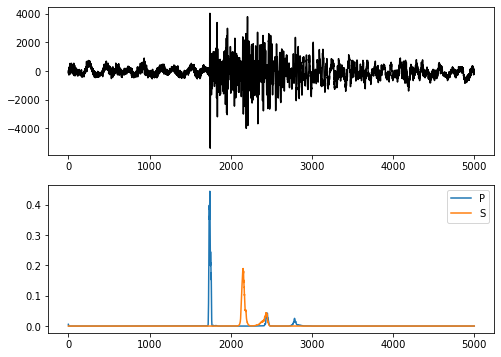

In [9]:
resp = requests.post(f'{PHASENET_API_URL}/predict_prob', json=req)
print(resp)
picks, preds = resp.json() 
preds = np.array(preds)
print('Picks', picks)

fig, axes = plt.subplots(2,1, figsize=(8,6))
axes[0].plot(data[:,-1], 'k', label="Z")
axes[1].plot(preds[0, :, 0, 1], label="P")
axes[1].plot(preds[0, :, 0, 2], label="S")
axes[1].legend()
plt.show();

## Detecting earthquakes from continuous data

For example, we can download one days' data using Obspy and detect earthquakes in it.

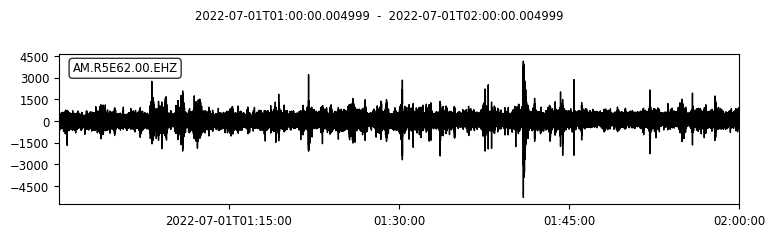

/Users/weiqiang/.local/miniconda3/lib/python3.8/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [34]:
client = Client("RASPISHAKE")

starttime = UTCDateTime("2022-07-01 01:00:00")
endtime = UTCDateTime("2022-07-01 02:00:00")
waveforms = client.get_waveforms(network="AM",
                                 station="R5E62",
                                 location="*",
                                 channel="EHZ", 
                                 starttime=starttime, 
                                 endtime=endtime)  
waveforms = waveforms.detrend()
waveforms = waveforms.merge(fill_value=0)
waveforms[0].plot();
waveforms.write("one-hour.mseed")

In [88]:
waveforms = obspy.read("one-hour.mseed")

- STA/LTA:

In [104]:
tr = waveforms[0]
cft = classic_sta_lta(tr.data, int(1 * tr.stats.sampling_rate), int(5 * tr.stats.sampling_rate))
on_of = trigger_onset(cft, 3.5, 1.0, max_len=1000)

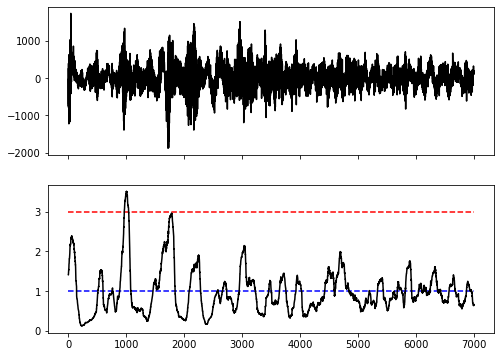

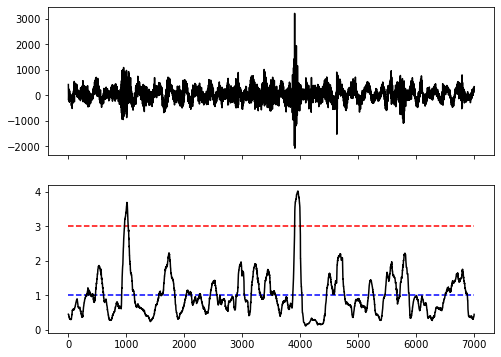

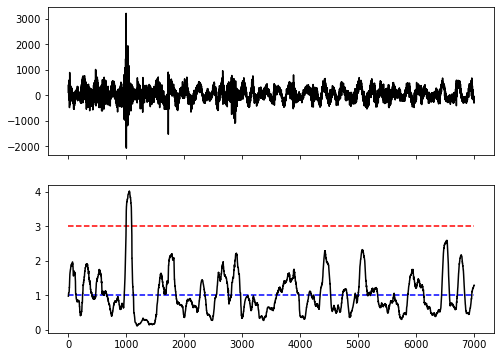

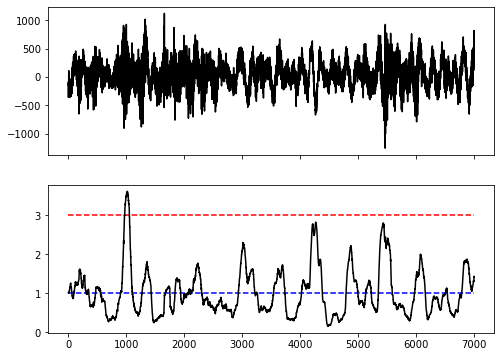

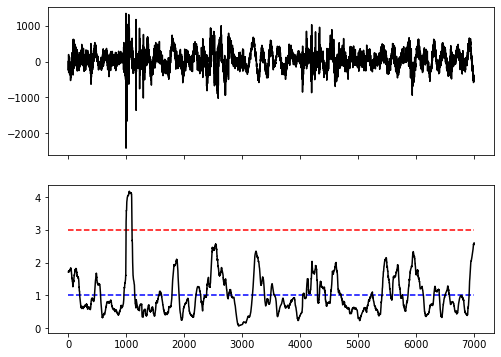

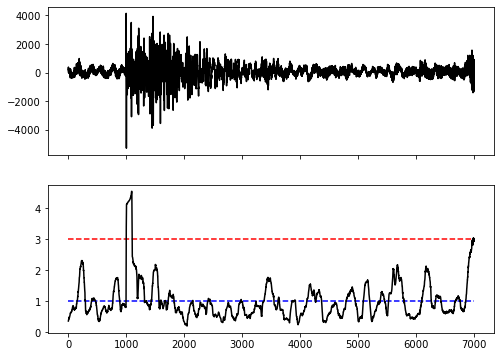

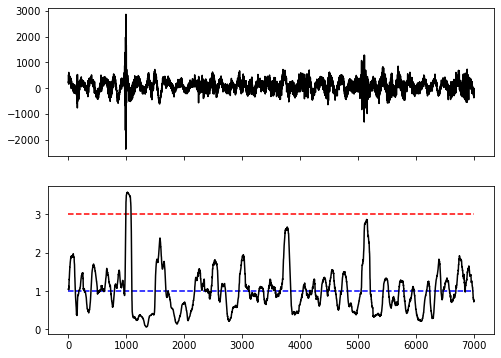

In [110]:
for (t0, tn) in on_of:
    t0 = t0 - 1000
    tn = t0 + 7000
    fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)
    axes[0].plot(tr.data[t0:tn], "k")
    ymin, ymax = axes[0].get_ylim()
    if len(on_of) > 0:
        axes[0].vlines(on_of[t0:tn, 0], ymin, ymax, color='r', linewidth=2)
        axes[0].vlines(on_of[t0:tn, 1], ymin, ymax, color='b', linewidth=2)
    axes[1].plot(cft[t0:tn], 'k')
    axes[1].hlines([3.0, 1.0], 0, len(cft[t0:tn]), color=['r', 'b'], linestyle='--')
    plt.show()
    # break

- PhaseNet

(360001, 3)
No event between 2022-07-01T01:40:41.000000Z and 2022-07-01T01:43:11.000000Z
No event between 2022-07-01T01:43:11.000000Z and 2022-07-01T01:45:41.000000Z
No event between 2022-07-01T01:45:41.000000Z and 2022-07-01T01:48:11.000000Z
No event between 2022-07-01T01:48:11.000000Z and 2022-07-01T01:50:41.000000Z
No event between 2022-07-01T01:50:41.000000Z and 2022-07-01T01:53:11.000000Z
No event between 2022-07-01T01:53:11.000000Z and 2022-07-01T01:55:41.000000Z
No event between 2022-07-01T01:55:41.000000Z and 2022-07-01T01:58:11.000000Z
No event between 2022-07-01T01:58:11.000000Z and 2022-07-01T02:00:41.000000Z
No event between 2022-07-01T02:00:41.000000Z and 2022-07-01T02:03:11.000000Z
No event between 2022-07-01T02:03:11.000000Z and 2022-07-01T02:05:41.000000Z
No event between 2022-07-01T02:05:41.000000Z and 2022-07-01T02:08:11.000000Z
No event between 2022-07-01T02:08:11.000000Z and 2022-07-01T02:10:41.000000Z
No event between 2022-07-01T02:10:41.000000Z and 2022-07-01T02:1

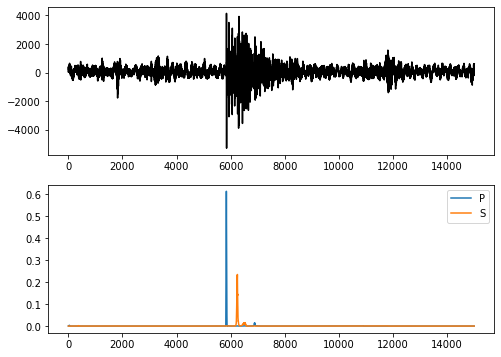

No event between 2022-07-01T02:23:11.000000Z and 2022-07-01T02:25:41.000000Z
No event between 2022-07-01T02:25:41.000000Z and 2022-07-01T02:28:11.000000Z
No event between 2022-07-01T02:28:11.000000Z and 2022-07-01T02:30:41.000000Z
No event between 2022-07-01T02:30:41.000000Z and 2022-07-01T02:33:11.000000Z
No event between 2022-07-01T02:33:11.000000Z and 2022-07-01T02:35:41.000000Z
No event between 2022-07-01T02:35:41.000000Z and 2022-07-01T02:38:11.000000Z
No event between 2022-07-01T02:38:11.000000Z and 2022-07-01T02:40:41.000000Z


In [109]:
data = []
data.append(np.zeros_like(waveforms[0].data))
data.append(np.zeros_like(waveforms[0].data))
for trace in waveforms[0:1]:
    data.append(trace.data)
data = np.array(data).T
data = data.astype("float32")
print(data.shape)

window_length = int(6000*2.5)
for i in range(0, len(data) - window_length, window_length): ## one minute
    data_id = waveforms[0].get_id()[:-1]
    timestamp = (starttime + i/100.0).datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]

    req = {"id": [data_id],
           "timestamp": [timestamp],
           "vec": [data[i:i+window_length].tolist()]}

    resp = requests.post(f'{PHASENET_API_URL}/predict_prob', json=req)
    # print(resp)
    picks, preds = resp.json() 
    preds = np.array(preds)
    if len(picks) > 0:
        print('Picks', picks)
        fig, axes = plt.subplots(2,1, figsize=(8,6))
        axes[0].plot(data[i:i+window_length,-1], 'k', label="Z")
        axes[1].plot(preds[0, :, 0, 1], label="P")
        axes[1].plot(preds[0, :, 0, 2], label="S")
        axes[1].legend()
        plt.show();
    else:
        print(f"No event between {starttime+i/100.0} and {starttime+i/100.0+window_length/100.0}")